In [13]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load data
data = pd.read_csv(r"C:\Users\bhara\Desktop\ML\DSN\1_target_ts.csv", parse_dates=["date"])

# Assign unique IDs for items and organizations
data['item_id'] = data['item'].astype("category").cat.codes
data['org_id'] = data['org'].astype("category").cat.codes

# Normalize the quantity
scaler = MinMaxScaler()
data['quantity_normalized'] = scaler.fit_transform(data[['quantity']])

# Split data into training and testing sets
train, test = train_test_split(data, test_size=0.2, random_state=42)

# Prepare TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((
    {'item_id': train['item_id'].values, 'org_id': train['org_id'].values},
    train['quantity_normalized'].values
)).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((
    {'item_id': test['item_id'].values, 'org_id': test['org_id'].values},
    test['quantity_normalized'].values
)).batch(32)

# Define model
class RecommendationModel(tf.keras.Model):
    def __init__(self, num_items, num_orgs, embedding_dim=50):
        super(RecommendationModel, self).__init__()
        self.item_embedding = tf.keras.layers.Embedding(num_items, embedding_dim)
        self.org_embedding = tf.keras.layers.Embedding(num_orgs, embedding_dim)
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.dense2 = tf.keras.layers.Dense(64, activation='relu')
        self.output_layer = tf.keras.layers.Dense(1, activation='sigmoid')
    
    def call(self, inputs):
        item_vector = self.item_embedding(inputs['item_id'])
        org_vector = self.org_embedding(inputs['org_id'])
        combined = tf.concat([item_vector, org_vector], axis=-1)
        x = self.dense1(combined)
        x = self.dense2(x)
        return self.output_layer(x)

# Initialize model
num_items = data['item_id'].nunique()
num_orgs = data['org_id'].nunique()
model = RecommendationModel(num_items=num_items, num_orgs=num_orgs)

# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train model
model.fit(train_ds, validation_data=test_ds, epochs=10)

# Prediction function
def recommend_items(org_id, top_n=5):
    org_vector = np.array([org_id] * num_items)
    item_vector = np.arange(num_items)
    predictions = model.predict({'item_id': item_vector, 'org_id': org_vector})
    top_items = np.argsort(-predictions.flatten())[:top_n]
    return data[data['item_id'].isin(top_items)]['item'].unique()

# Example usage
org_id = data['org_id'].iloc[0]  # Replace with the desired org_id
print("Recommended Items:", recommend_items(org_id))


Epoch 1/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0557 - mae: 0.1445 - val_loss: 3.4204e-04 - val_mae: 0.0090
Epoch 2/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0815e-04 - mae: 0.0085 - val_loss: 3.5417e-04 - val_mae: 0.0082
Epoch 3/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2442e-04 - mae: 0.0064 - val_loss: 3.6525e-04 - val_mae: 0.0076
Epoch 4/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2076e-04 - mae: 0.0059 - val_loss: 3.6436e-04 - val_mae: 0.0073
Epoch 5/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1780e-04 - mae: 0.0056 - val_loss: 3.6748e-04 - val_mae: 0.0071
Epoch 6/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1576e-04 - mae: 0.0054 - val_loss: 3.7215e-04 - val_mae: 0.0070
Epoch 7/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1523e-04 - mae: 0.0053 - val_loss: 3.7171e-04 - val_mae: 0.0069
Epoch 8/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1367e-04 - mae: 0.0051 - val_loss: 3.7084e-04 - val_mae: 0.0

Epoch 1/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4.3624e-04 - mae: 0.0091 - mse: 4.3624e-04 - rmse: 0.0207 - val_loss: 3.7532e-04 - val_mae: 0.0072 - val_mse: 3.7532e-04 - val_rmse: 0.0194
Epoch 2/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2049e-04 - mae: 0.0059 - mse: 3.2049e-04 - rmse: 0.0177 - val_loss: 3.4388e-04 - val_mae: 0.0059 - val_mse: 3.4388e-04 - val_rmse: 0.0185
Epoch 3/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1449e-04 - mae: 0.0054 - mse: 3.1449e-04 - rmse: 0.0175 - val_loss: 3.3053e-04 - val_mae: 0.0062 - val_mse: 3.3053e-04 - val_rmse: 0.0182
Epoch 4/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0713e-04 - mae: 0.0050 - mse: 3.0713e-04 - rmse: 0.0173 - val_loss: 3.3025e-04 - val_mae: 0.0060 - val_mse: 3.3025e-04 - val_rmse: 0.0182
Epoch 5/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.0523e-04 - mae: 0.0050 - mse: 3.0523e-04 - rmse: 0.0172 - val_loss: 3.2590e-04 - val_mae: 0.0060 - val_mse: 3.2590e-04 - val_rmse: 0.0181


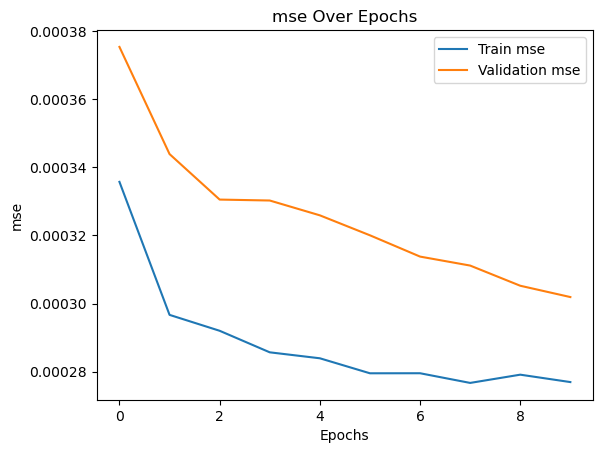

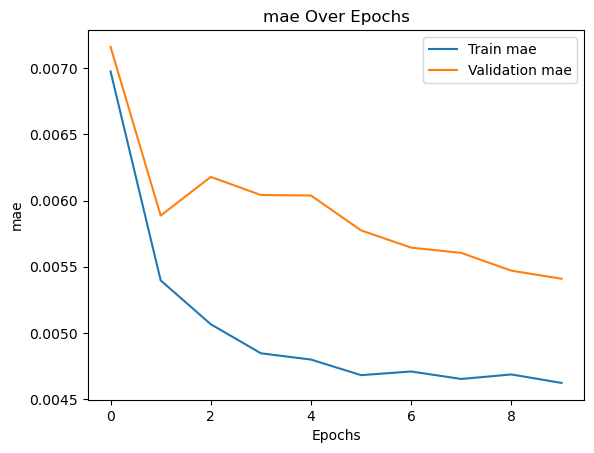

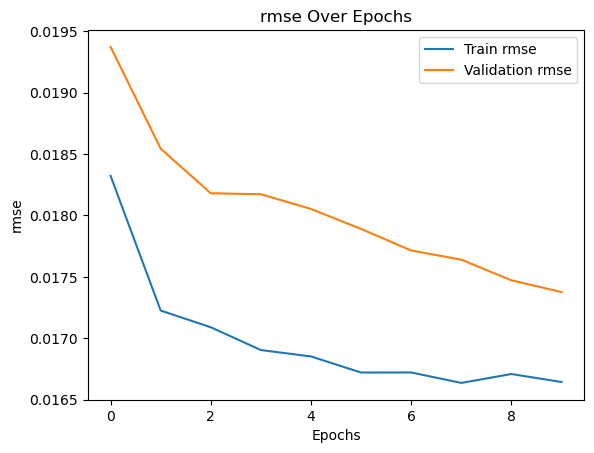

In [15]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load data
data = pd.read_csv(r"C:\Users\bhara\Desktop\ML\DSN\1_target_ts.csv", parse_dates=["date"])

# Assign unique IDs for items and organizations
data['item_id'] = data['item'].astype("category").cat.codes
data['org_id'] = data['org'].astype("category").cat.codes

# Normalize the quantity
scaler = MinMaxScaler()
data['quantity_normalized'] = scaler.fit_transform(data[['quantity']])

# Split data into training and testing sets
train, test = train_test_split(data, test_size=0.2, random_state=42)

# Prepare TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((
    {'item_id': train['item_id'].values, 'org_id': train['org_id'].values},
    train['quantity_normalized'].values
)).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((
    {'item_id': test['item_id'].values, 'org_id': test['org_id'].values},
    test['quantity_normalized'].values
)).batch(32)

# Define model
class RecommendationModel(tf.keras.Model):
    def __init__(self, num_items, num_orgs, embedding_dim=50):
        super(RecommendationModel, self).__init__()
        self.item_embedding = tf.keras.layers.Embedding(num_items, embedding_dim)
        self.org_embedding = tf.keras.layers.Embedding(num_orgs, embedding_dim)
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.dense2 = tf.keras.layers.Dense(64, activation='relu')
        self.output_layer = tf.keras.layers.Dense(1)
    
    def call(self, inputs):
        item_vector = self.item_embedding(inputs['item_id'])
        org_vector = self.org_embedding(inputs['org_id'])
        combined = tf.concat([item_vector, org_vector], axis=-1)
        x = self.dense1(combined)
        x = self.dense2(x)
        return self.output_layer(x)

# Initialize model
num_items = data['item_id'].nunique()
num_orgs = data['org_id'].nunique()
model = RecommendationModel(num_items=num_items, num_orgs=num_orgs)

# Compile model with regression metrics
model.compile(optimizer='adam', 
              loss='mse', 
              metrics=[tf.keras.metrics.MeanSquaredError(name='mse'),
                       tf.keras.metrics.MeanAbsoluteError(name='mae'),
                       tf.keras.metrics.RootMeanSquaredError(name='rmse')])

# Train model
history = model.fit(train_ds, validation_data=test_ds, epochs=10)

# Plot metrics
import matplotlib.pyplot as plt

def plot_metric(history, metric_name):
    plt.plot(history.history[metric_name], label=f'Train {metric_name}')
    plt.plot(history.history[f'val_{metric_name}'], label=f'Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} Over Epochs')
    plt.legend()
    plt.show()

# Plot MSE, MAE, RMSE
plot_metric(history, 'mse')
plot_metric(history, 'mae')
plot_metric(history, 'rmse')


In [17]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# Get model predictions for the test dataset
predictions = []
true_values = []

for inputs, targets in test_ds:
    pred = model.predict(inputs)
    predictions.extend(pred.flatten())
    true_values.extend(targets.numpy())

# Calculate Total MSE and RMSE
total_mse = mean_squared_error(true_values, predictions)
total_rmse = np.sqrt(total_mse)

# Print the results
print(f"Total MSE: {total_mse}")
print(f"Total RMSE: {total_rmse}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━